# Data Analytics 

In this notebook, we use the data saved in parquet format in the first notebook, to do the data analytics. This notebook contains the follwoing sections.

* [1. Import Libraries](#load_libraries)
* [2. Load Data](#load_data)
* [3. Top Ranked Products](#top_products)
* [4. Influence of Price on Ranking](#price_ranking_relationship)
* [5. Map Visualization](#map_visualization)
* [6. Miscellaneous Statistics](#miscellaneous_statistics)
* [7. Time Measurement](#time_measurement)

## 1. import Libraries
<a id='load_libraries'></a>

In [1]:
import sparky
import pyspark
import pyspark.sql
sc = sparky.connect("sparknotebook-Gruppe_3", 2)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

~~~ Sparky module loaded ~~~


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/09 15:16:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/09 15:16:21 WARN Utils: Service 'sparkDriver' could not bind on port 5555. Attempting port 5556.
23/07/09 15:16:21 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 4444. Attempting port 4445.


Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 2 cores; real number might be less.


In [2]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import time
import pyspark.sql.functions as F
import pandas as pd

In [3]:
# Install package necessary for heatmap if necessary, installation make take some time
%pip install geopandas

In [4]:
import geopandas as gpd # This libraries is not yet installed on the ZHAW Jupyter platform, 
                        #a reuest has been make but no feedback until now
    
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path

## 2. Load Data
<a id='load_data'></a>

In [7]:
parquet_file_path = Path("./data")
parquet_file = "processed_comparis_home_results.parquet"

# Join the path and file name using the Path object
data_file = str(parquet_file_path / parquet_file)

In [8]:
df_results = spark.read.parquet(data_file)
df_results.printSchema()

root
 |-- BuildingZipCode: string (nullable = true)
 |-- RequestedHouseholdSportsEquipmentValueCompensation: boolean (nullable = true)
 |-- RequestedHouseholdInsuranceSum: long (nullable = true)
 |-- NumberOfAdults: long (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- NumberOfChildren: long (nullable = true)
 |-- RequestedPrivateLiabilityDeductible: long (nullable = true)
 |-- HouseType: long (nullable = true)
 |-- Guid: string (nullable = true)
 |-- SquareMeters: long (nullable = true)
 |-- NumberOfRooms: double (nullable = true)
 |-- RequestedHouseholdGlassCoverage: boolean (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- RequestedHouseholdSimpleTheftDeductible: long (nullable = true)
 |-- RequestedPrivateLiabilityThirdPartyVehicles: boolean (nullable = true)
 |-- RequestedPrivateLiabilityInsuranceSum: long (nullable = true)
 |-- InsuranceType: long (nullable = true)
 |-- Floor: long (nullable = true)
 |-- Canton: string (nullable = true)
 |-- Produ

In [9]:
# Insurance Products in the DataFrame are labeled with numbers from 1 to 3 as below.
insurance_type_labels = {
    "1": "Hausrat",
    "2": "Privathaftpflicht",
    "3": "Hausrat & Privathaftpflicht"
}

insurance_types = insurance_type_labels.keys()

In [10]:
print(df_results.select("GUID").distinct().count())

2163


## 3. Top Ranked Products
<a id='top_products'></a>

In [51]:
#Daten auswählen, gruppieren und aggregieren
df_produktpositions = df_results.select("InsuranceType", "Product", "ProductPosition", "TotalPremium", "MatchingOffer")
df_number_of_top_positions = df_produktpositions \
    .filter((col("MatchingOffer") == True) & (col("ProductPosition") <= 3)) \
    .groupBy("InsuranceType", "Product") \
    .agg({"Product": "count", "TotalPremium": "avg"}) \
    .withColumnRenamed("count(Product)", "NumberOfTop3Ranks") \
    .withColumnRenamed("avg(TotalPremium)", "AverageTotalPremium") \
    .orderBy(col("InsuranceType"), col("NumberOfTop3Ranks").desc())
df_number_of_top_positions.cache()

DataFrame[InsuranceType: bigint, Product: string, AverageTotalPremium: double, NumberOfTop3Ranks: bigint]

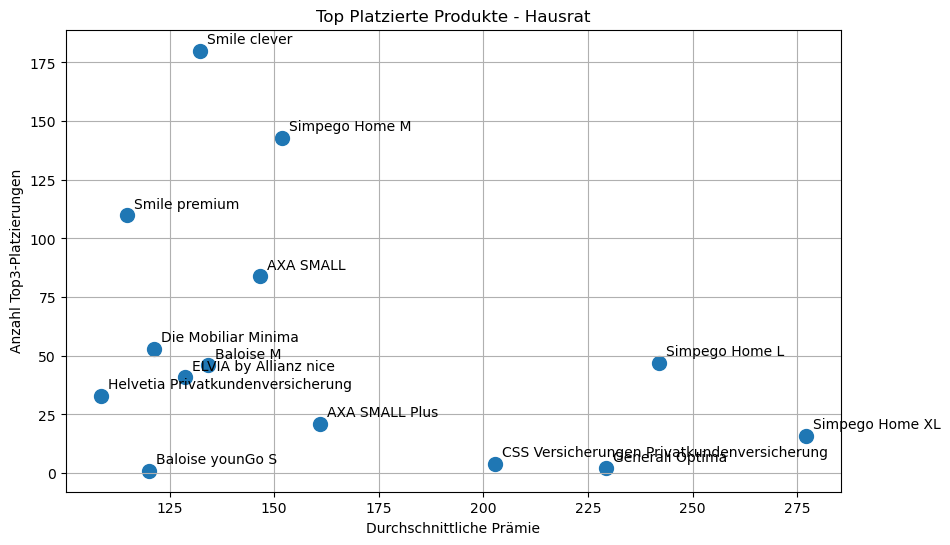

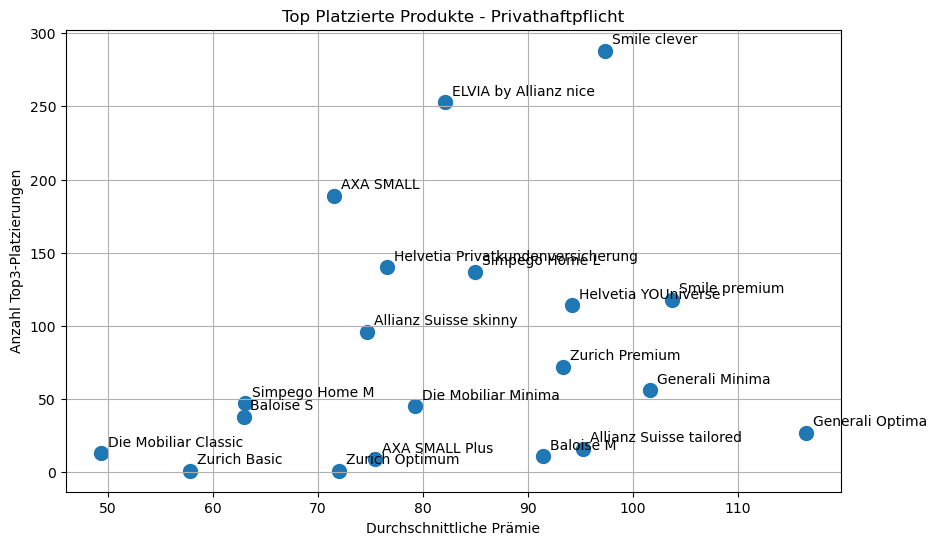

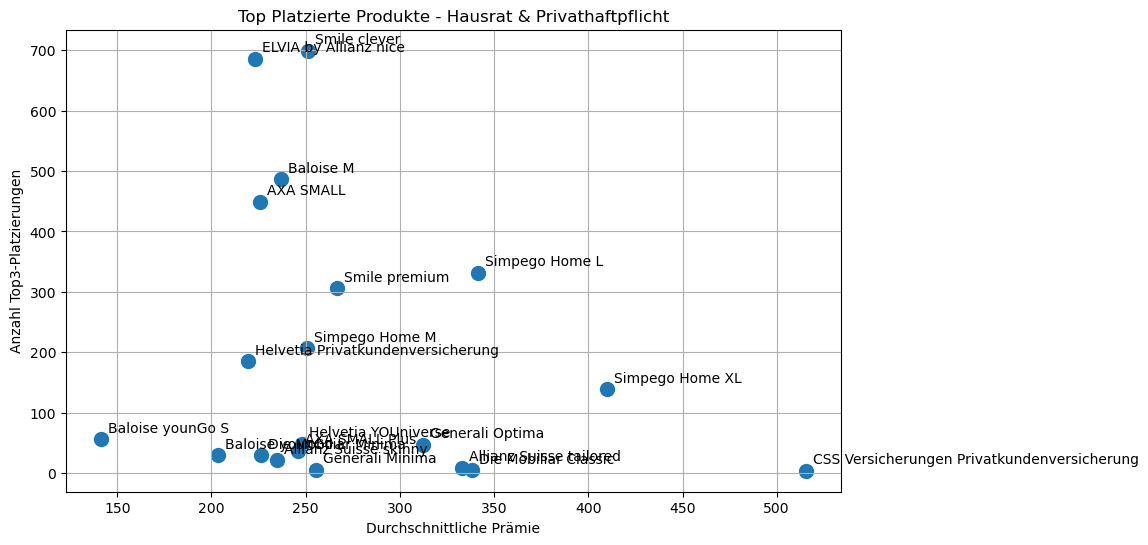

In [52]:
def create_plot(insurance_type):
    filtered_result = df_number_of_top_positions.filter(df_number_of_top_positions["InsuranceType"] == insurance_type)

    x = filtered_result.select("AverageTotalPremium").toPandas()["AverageTotalPremium"]
    y = filtered_result.select("NumberOfTop3Ranks").toPandas()["NumberOfTop3Ranks"]
    labels = filtered_result.select("Product").toPandas()

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=100)
    plt.xlabel("Durchschnittliche Prämie")
    plt.ylabel("Anzahl Top3-Platzierungen")
    plt.title("Top Platzierte Produkte - {}".format(insurance_type_labels[insurance_type]))
    plt.grid(True)

    for i, label in labels.iterrows():
        plt.annotate(label["Product"], (x[i], y[i]), xytext=(5, 5), textcoords='offset points')

    plt.show()

for insurance_type in insurance_types:
    create_plot(insurance_type)

## 4. Influence of Price on Product Ranking
<a id='price_ranking_relationship'></a>

In [53]:
df_firstpremiums = df_results \
    .select("ProductPosition", "TotalPremium", "MatchingOffer", "GUID") \
    .filter((col("MatchingOffer") == True) & (col("ProductPosition") == 1)) \
    .groupBy("GUID") \
    .agg({"TotalPremium": "min"}) \
    .withColumnRenamed("min(TotalPremium)", "FirstPlacePremium")
df_firstpremiums.show()


+--------------------+-----------------+
|                GUID|FirstPlacePremium|
+--------------------+-----------------+
|85069460-c3d5-456...|            257.6|
|99a779f7-c925-4c8...|            120.0|
|a7f7ab9f-984e-486...|            182.8|
|c79e271f-b615-4c9...|             65.0|
|8e9892fa-fab8-4e3...|            141.3|
|990fa056-996a-4ad...|            135.6|
|9a53a60b-c986-493...|             65.4|
|bd52c673-ffb9-41d...|            297.3|
|e6c48fe8-9745-432...|             99.5|
|a8315e79-3b70-489...|             67.5|
|d4359831-8772-4cf...|            143.4|
|86e8df31-1abf-434...|            219.4|
|90e8509c-4434-4d4...|            248.3|
|a20933d0-43f9-4cf...|            120.0|
|f20b87ae-8cca-4e8...|            262.6|
|8699a080-764b-4b7...|             72.9|
|b99f63c8-0d98-497...|             67.5|
|e42367c3-0139-44c...|            308.5|
|fb5dbac5-627a-438...|             77.0|
|8c20f616-23dc-421...|            199.0|
+--------------------+-----------------+
only showing top

In [54]:
df_premiums_normed = df_results \
    .select("InsuranceType", "ProductPosition", "TotalPremium", "MatchingOffer", "GUID") \
    .filter((col("MatchingOffer") == True)) \
    .join(df_firstpremiums, "GUID") \
    .withColumn("PriceIndex", col("TotalPremium") / col("FirstPlacePremium"))
df_premiums_normed.show()

+--------------------+-------------+---------------+------------+-------------+-----------------+------------------+
|                GUID|InsuranceType|ProductPosition|TotalPremium|MatchingOffer|FirstPlacePremium|        PriceIndex|
+--------------------+-------------+---------------+------------+-------------+-----------------+------------------+
|2732bbb0-da6a-440...|            1|             15|       280.0|         true|             91.5| 3.060109289617486|
|2732bbb0-da6a-440...|            1|             14|      202.76|         true|             91.5|2.2159562841530054|
|2732bbb0-da6a-440...|            1|             13|       200.0|         true|             91.5| 2.185792349726776|
|2732bbb0-da6a-440...|            1|             12|       184.3|         true|             91.5| 2.014207650273224|
|2732bbb0-da6a-440...|            1|             11|       165.3|         true|             91.5|1.8065573770491805|
|2732bbb0-da6a-440...|            1|             10|       161.5

In [55]:
df_premiums_normed.filter(df_premiums_normed["InsuranceType"] == "1").select("ProductPosition").toPandas()["ProductPosition"]

0       11
1       10
2        9
3        8
4        7
        ..
4165     2
4166     1
4167     3
4168     2
4169     1
Name: ProductPosition, Length: 4170, dtype: int64

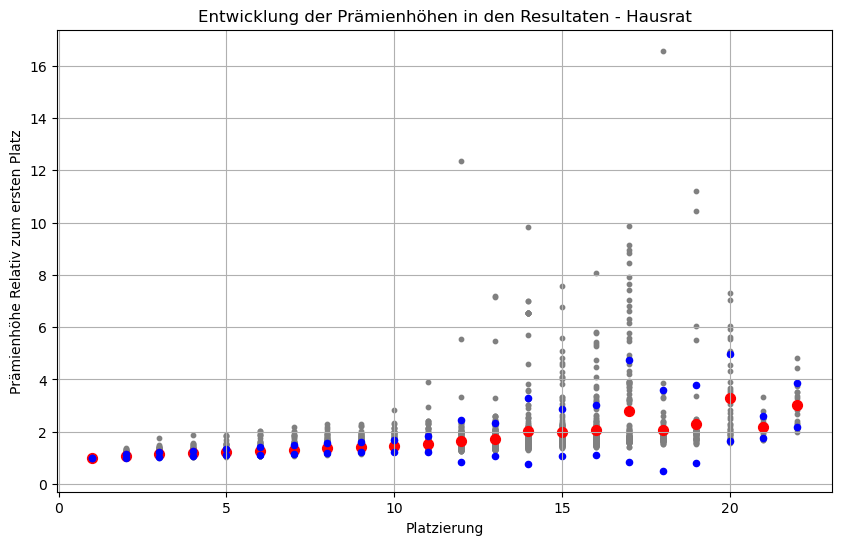

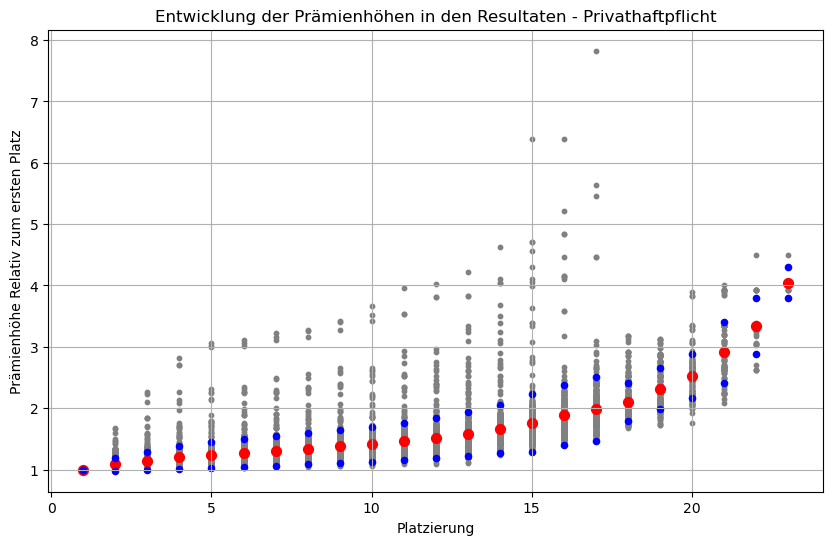

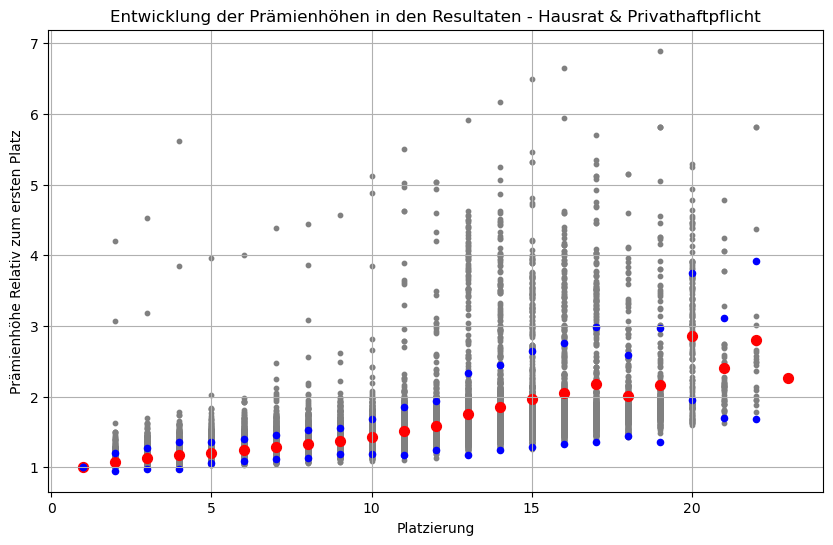

In [56]:
insurance_types = df_number_of_top_positions.select("InsuranceType").distinct().orderBy("InsuranceType").toPandas()["InsuranceType"].astype(str).tolist()

def create_plot_1(insurance_type):
    filtered_result = df_premiums_normed.filter(df_premiums_normed["InsuranceType"] == insurance_type)
    avg_result = filtered_result.withColumn("PI2", col("PriceIndex")).groupBy("ProductPosition") \
        .agg({"PriceIndex": "avg", "PI2": "stddev"}) \
        .withColumnRenamed("avg(PriceIndex)", "AvgPriceIndex") \
        .withColumnRenamed("stddev(PI2)", "stdDevPriceIndex")
        
    df_result =  filtered_result.select("ProductPosition", "PriceIndex").toPandas()
    x = df_result["ProductPosition"]
    y = df_result["PriceIndex"]
    
    df_averages = avg_result.select("ProductPosition", "AvgPriceIndex", "stdDevPriceIndex") \
        .withColumn("UpperDev", col("AvgPriceIndex") + col("stdDevPriceIndex")) \
        .withColumn("LowerDev", col("AvgPriceIndex") - col("stdDevPriceIndex")) \
        .toPandas()
    
    x2 = df_averages["ProductPosition"]
    y2 = df_averages["AvgPriceIndex"]
    y2a = df_averages["UpperDev"]
    y2b = df_averages["LowerDev"]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=10, c="gray")
    plt.scatter(x2, y2, s=50, c="red")
    plt.scatter(x2, y2a, s=20, c="blue")
    plt.scatter(x2, y2b, s=20, c="blue")
    plt.xlabel("Platzierung")
    plt.ylabel("Prämienhöhe Relativ zum ersten Platz")
    plt.title("Entwicklung der Prämienhöhen in den Resultaten - {}".format(insurance_type_labels[insurance_type]))
    plt.grid(True)

    plt.show()

for insurance_type in insurance_types:
    create_plot_1(insurance_type)

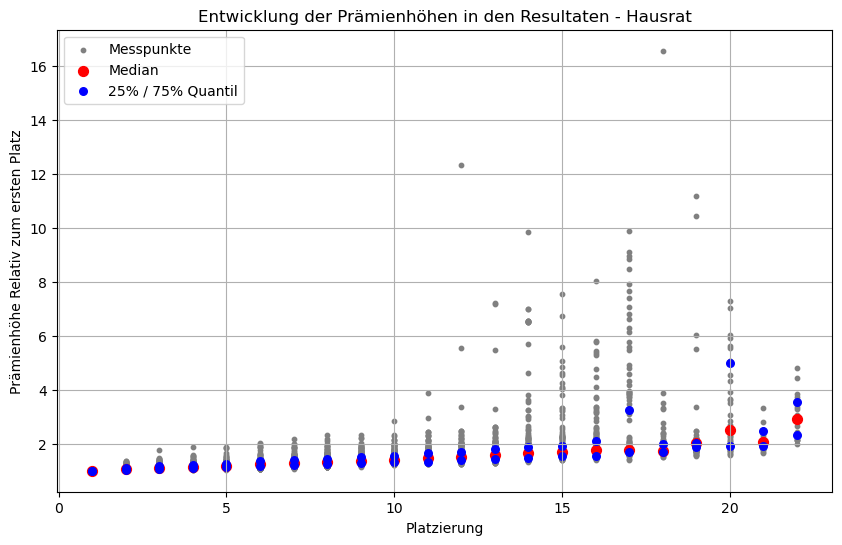

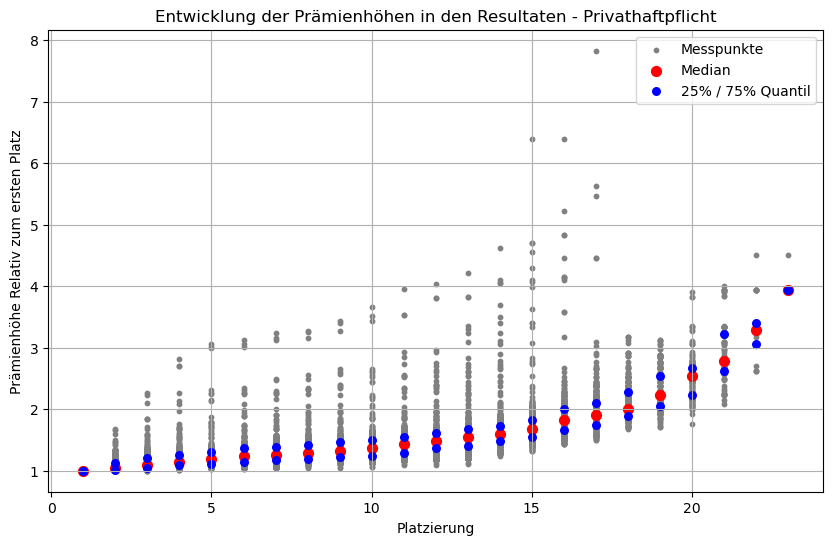

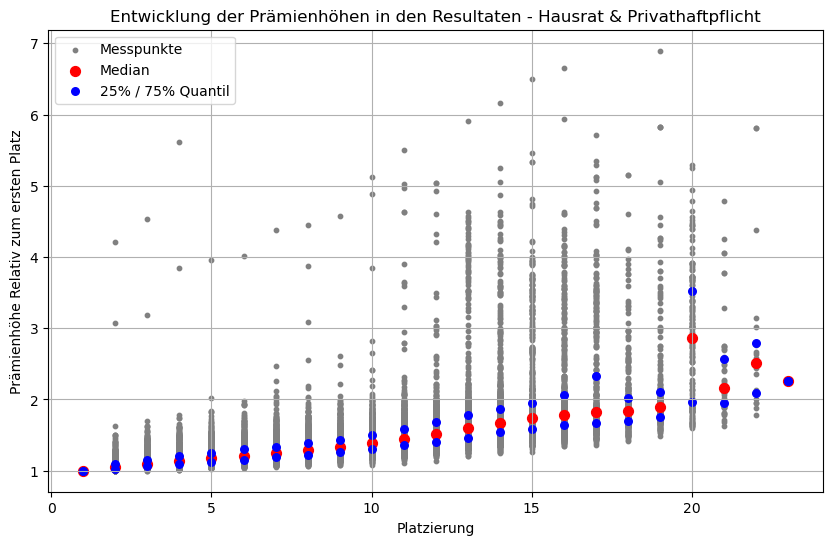

In [57]:
def create_plot_2(insurance_type):
    filtered_result = df_premiums_normed.filter(df_premiums_normed["InsuranceType"] == insurance_type)
    avg_result = filtered_result \
        .withColumn("PI2", col("PriceIndex")) \
        .withColumn("PI3", col("PriceIndex")) \
        .groupBy("ProductPosition") \
        .agg(F.median(col("PriceIndex")), F.percentile_approx(col("PI2"),0.75), F.percentile_approx(col("PI2"),0.25)) \
        .withColumnRenamed("median(PriceIndex)", "MedianPrice") \
        .withColumnRenamed("percentile_approx(PI2, 0.75, 10000)", "75%Quantil") \
        .withColumnRenamed("percentile_approx(PI2, 0.25, 10000)", "25%Quantil")
    df_avgs = avg_result.select("ProductPosition", "MedianPrice", "75%Quantil", "25%Quantil").toPandas()
    df_result = filtered_result.select("ProductPosition", "PriceIndex").toPandas()
    
    x = df_result["ProductPosition"]
    y = df_result["PriceIndex"]
    
    x2 = df_avgs["ProductPosition"]
    y2 = df_avgs["MedianPrice"]
    y2a = df_avgs["75%Quantil"]
    y2b = df_avgs["25%Quantil"]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=10, c = "grey")
    plt.scatter(x2, y2, s=50, c="red")
    plt.scatter(x2, y2a, s=30, c="blue")
    plt.scatter(x2, y2b, s=30, c="blue")
    plt.xlabel("Platzierung")
    plt.ylabel("Prämienhöhe Relativ zum ersten Platz")
    plt.title("Entwicklung der Prämienhöhen in den Resultaten - {}".format(insurance_type_labels[insurance_type]))
    plt.grid(True)
    plt.legend(['Messpunkte', 'Median', '25% / 75% Quantil'])

    plt.show()

for insurance_type in insurance_types:
    create_plot_2(insurance_type)

## 5. Map Visualization
<a id='map_visualization'></a>

In [58]:
shape_file_path = Path("./data/swiss_shapes")
shape_file = "swissBOUNDARIES3D_1_4_TLM_KANTONSGEBIET.shp"

# Join the path and file name using the Path object
fp = str(shape_file_path / shape_file)

# read the shapefile of Swiss cantons into a GeoDataFrame
canton_map = gpd.read_file(fp)

In [59]:
canton_map['NAME'].unique()

array(['Graubünden', 'Bern', 'Valais', 'Vaud', 'Ticino', 'St. Gallen',
       'Zürich', 'Fribourg', 'Luzern', 'Aargau', 'Uri', 'Thurgau',
       'Schwyz', 'Jura', 'Neuchâtel', 'Solothurn', 'Glarus',
       'Basel-Landschaft', 'Obwalden', 'Nidwalden', 'Genève',
       'Schaffhausen', 'Appenzell Ausserrhoden', 'Zug',
       'Appenzell Innerrhoden', 'Basel-Stadt'], dtype=object)

The names of the cantons will be converted into abbreviations to match the information in df_results.

In [60]:
cantons = {
    'Zürich': 'ZH',
    'Bern': 'BE',
    'Luzern': 'LU',
    'Uri': 'UR',
    'Schwyz': 'SZ',
    'Obwalden': 'OW',
    'Nidwalden': 'NW',
    'Glarus': 'GL',
    'Zug': 'ZG',
    'Fribourg': 'FR',
    'Solothurn': 'SO',
    'Basel-Stadt': 'BS',
    'Basel-Landschaft': 'BL',
    'Schaffhausen': 'SH',
    'Appenzell Ausserrhoden': 'AR',
    'Appenzell Innerrhoden': 'AI',
    'St. Gallen': 'SG',
    'Graubünden': 'GR',
    'Aargau': 'AG',
    'Thurgau': 'TG',
    'Ticino': 'TI',
    'Vaud': 'VD',
    'Valais': 'VS',
    'Neuchâtel': 'NE',
    'Genève': 'GE',
    'Jura': 'JU'
}

canton_map = canton_map.replace({'NAME':cantons})

In [61]:
# A check to make sure the transformaiton has been done.
canton_map['NAME'].unique()

array(['GR', 'BE', 'VS', 'VD', 'TI', 'SG', 'ZH', 'FR', 'LU', 'AG', 'UR',
       'TG', 'SZ', 'JU', 'NE', 'SO', 'GL', 'BL', 'OW', 'NW', 'GE', 'SH',
       'AR', 'ZG', 'AI', 'BS'], dtype=object)

In [62]:
#Convert spark dataframe to pandas dataframe
df_pd_results = df_results.toPandas()

23/07/07 20:15:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [63]:
# Products types are labeled as numbers so below the labels are changed to text
insurance_type_labels = {
    1: "Hausrat",
    2: "Privathaftpflicht",
    3: "Hausrat & Privathaftpflicht"
}

df_pd_results['InsuranceType'] = df_pd_results['InsuranceType'].map(insurance_type_labels)

In [64]:
# join the data with the shapefile by canton name
canton_data = canton_map.merge(df_pd_results, left_on='NAME', right_on='Canton')

In [65]:
# Perform the average calculation using groupBy and mean
df_average_premium_canton_product = df_pd_results.groupby(['Canton','InsuranceType'], as_index=False)['TotalPremium'].mean().reset_index().sort_values('TotalPremium', ascending=False)

df_average_premium_canton = df_pd_results.groupby(['Canton'], as_index=False)['TotalPremium'].mean().reset_index().sort_values('TotalPremium', ascending=False)


In [66]:
# join swiss canton shape dataframe
average_premium_canton_product = canton_map.merge(df_average_premium_canton_product, left_on="NAME", right_on="Canton")
average_premium_canton = canton_map.merge(df_average_premium_canton, left_on="NAME", right_on="Canton")

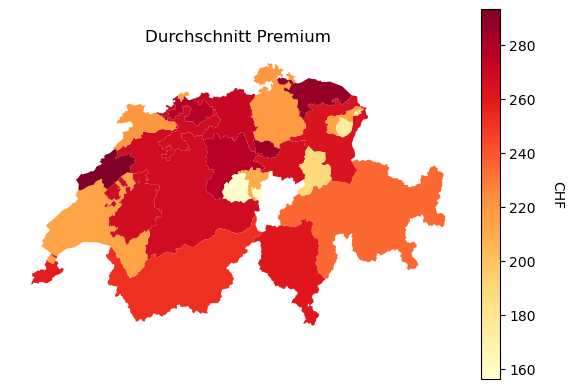

In [67]:
# colormap scale definitions
min_premium_average = average_premium_canton["TotalPremium"].min()
max_premium_average = average_premium_canton["TotalPremium"].max()

# color map defintions
color_map = "YlOrRd"

ax = average_premium_canton.plot(
    column="TotalPremium",
    cmap=color_map,
    linewidth=0.1,
    legend=False,
    vmin=min_premium_average,
    vmax=max_premium_average,
)
ax.axis("off")
ax.set_title("Durchschnitt Premium")

# extract axes object from GeoAxesSubplot
ax = ax.axes
# create and add colorbar
sm = plt.cm.ScalarMappable(
    cmap=color_map,
    norm=plt.Normalize(vmin=min_premium_average, vmax=max_premium_average),
)
cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.03)
cbar.ax.set_ylabel("CHF", rotation=270, labelpad=20)
plt.show()

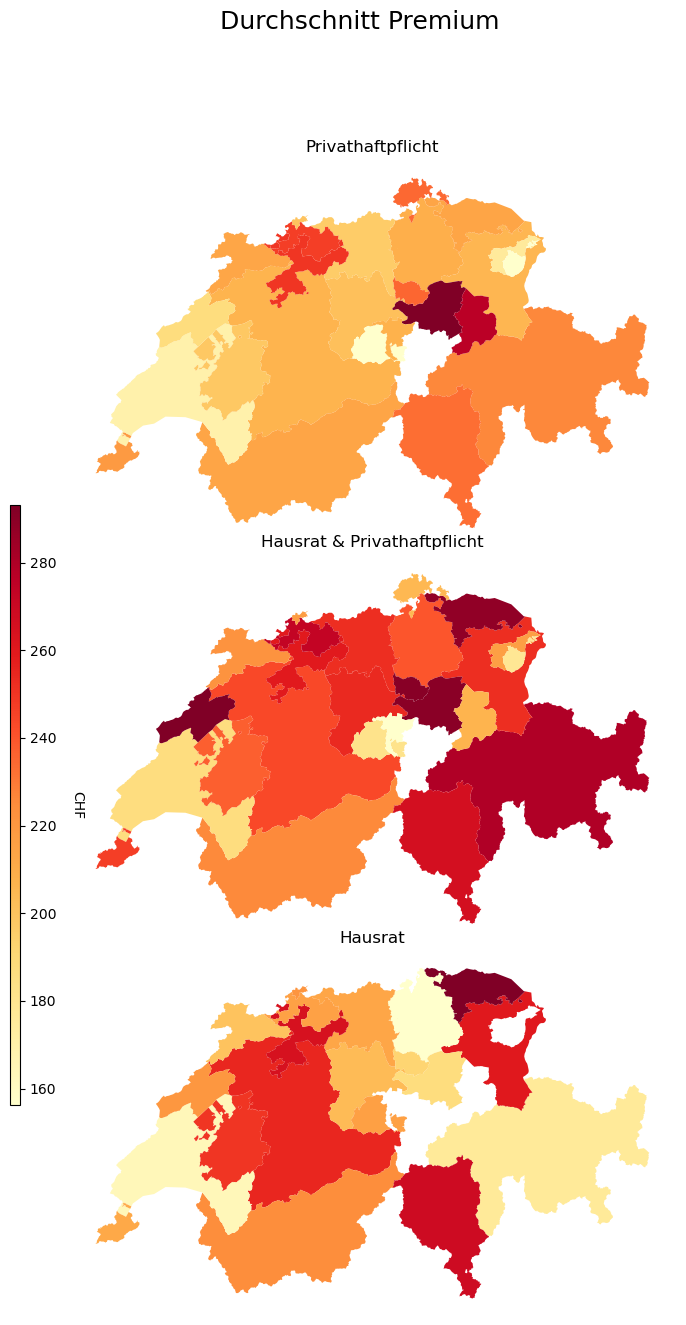

In [68]:
# create a grid of subplots for each product type

# Set the range for the choropleth
title = 'Durchschnitt Premium'
col = 'TotalPremium'
#source = 'Source: ...'
vmin = canton_data[col].min()
vmax = canton_data[col].max()
cmap = 'YlOrRd'

fig = plt.figure(figsize=(10, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 1), axes_pad=0.1)


# loop over each year and create a heatmap on the corresponding subplot
coverage = df_pd_results['InsuranceType'].unique()
for i, ins_type in enumerate(coverage):
    coverage_data = average_premium_canton_product[average_premium_canton_product['InsuranceType']==ins_type]
    ax = grid[i]
    ax.axis('off')
    ax.set_title(str(ins_type))
    coverage_data.plot(column=col, cmap=cmap, linewidth=1, ax=ax)
    
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min_premium_average, vmax=max_premium_average), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
cbar.ax.set_ylabel("CHF", rotation=270, labelpad=20)

fig.suptitle(title, fontsize=18)

plt.show()

## 6. Miscellaneous statistics
<a id='miscellaneous_statistics'></a>

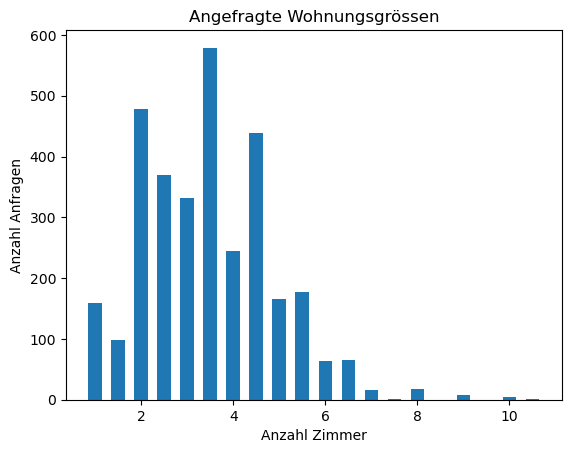

In [70]:
from pyspark.sql.functions import col

df_rooms = df_results \
    .select("NumberOfRooms", "ProductPosition") \
    .where((col("ProductPosition") == 1) & (col("NumberOfRooms") > 0)) \
    .groupBy(col("NumberOfRooms")) \
    .agg({"ProductPosition": "count"}) \
    .withColumnRenamed("count(ProductPosition)", "AnzahlAnfragen") \
    .toPandas()

plt.bar(df_rooms["NumberOfRooms"], df_rooms["AnzahlAnfragen"], 0.3)
plt.xlabel("Anzahl Zimmer")
plt.ylabel("Anzahl Anfragen")
plt.title("Angefragte Wohnungsgrössen")
plt.show()

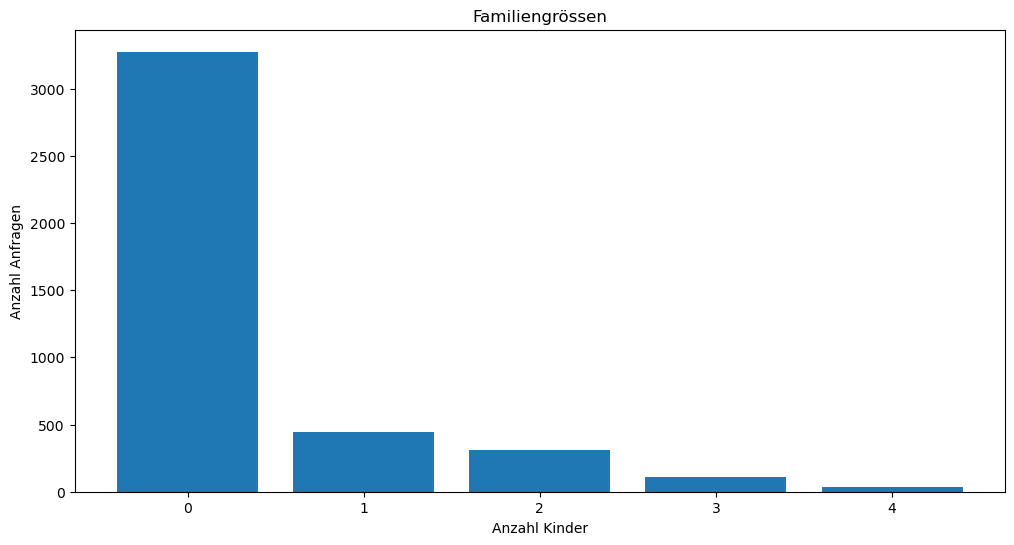

In [71]:
df_kids = df_results \
    .select("NumberOfChildren", "ProductPosition") \
    .where((col("ProductPosition") == 1) & (col("NumberOfChildren") >= 0)) \
    .groupBy(col("NumberOfChildren")) \
    .agg({"ProductPosition": "count"}) \
    .withColumnRenamed("count(ProductPosition)", "AnzahlAnfragen") \
    .toPandas()

plt.figure(figsize=(12, 6))
plt.bar(df_kids["NumberOfChildren"], df_kids["AnzahlAnfragen"], 0.8)
plt.xlabel("Anzahl Kinder")
plt.ylabel("Anzahl Anfragen")
plt.title("Familiengrössen")
plt.show()

In [72]:
#quelle: https://de.wikipedia.org/wiki/Kanton_(Schweiz)

df_dichte = pd.DataFrame.from_dict({ \
    "Kanton" : ["BS","GE","ZH","BL","ZG","AG","SO","TG","LU","SH","SG","VD","AR","NE","FR","SZ","BE","NW","TI","AI","JU","OW","VS","GL","UR","GR","FL"], \
    "Bevölkerung" : [196036,509448,1564662,292817,129787,703086,280245,285964,420326,83995,519245,822968,55585,176166,329809,163689,1047473,43894,352181,16360,73798,38435,353209,41190,37047,201376,39680], \
    "Dichte" : [5305,1803,905,566,544,501,355,288,281,281,256,256,229,220,197,180,176,159,125,95,88,78,68,60,34,28,247] \
})
df_dichte.set_index("Kanton", inplace = True)

df_cantons = df_results \
    .select("Canton", "GUID") \
    .groupBy(col("Canton")) \
    .agg(F.countDistinct("GUID").alias("AnzahlAnfragen")) \
    .orderBy("AnzahlAnfragen") \
    .toPandas() \
    .join(df_dichte, on='Canton')
df_cantons["AnfragenPro1000"] = df_cantons["AnzahlAnfragen"]*1000.0/df_cantons["Bevölkerung"]
df_cantons
  


,Canton,AnzahlAnfragen,Bevölkerung,Dichte,AnfragenPro1000
0,AI,2,16360,95,0.122249
1,NW,5,43894,159,0.113911
2,AR,5,55585,229,0.089952
3,OW,6,38435,78,0.156108
4,GL,7,41190,60,0.169944
5,FL,7,39680,247,0.176411
6,JU,15,73798,88,0.203258
7,SH,21,83995,281,0.250015
8,SZ,24,163689,180,0.146620
9,NE,27,176166,220,0.153265


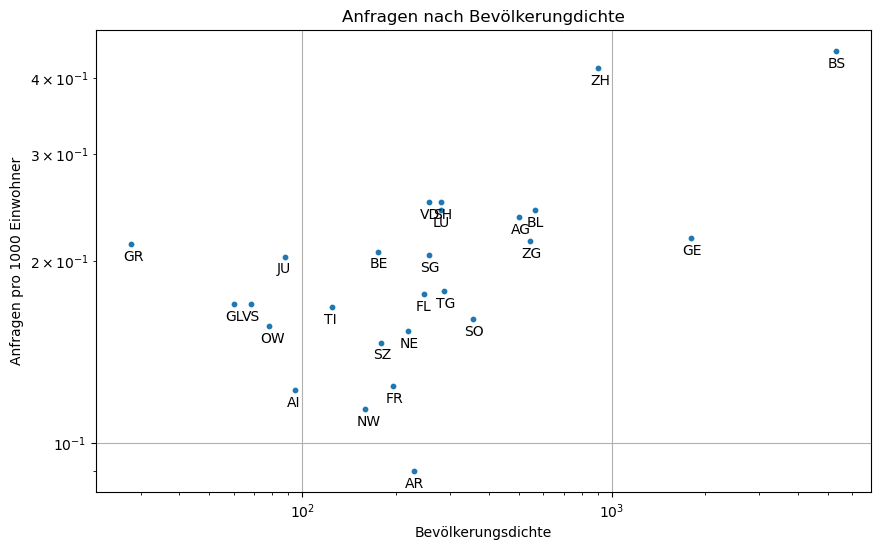

In [73]:

plt.figure(figsize=(10, 6))
plt.scatter(df_cantons['Dichte'], df_cantons['AnfragenPro1000'], s=10)
plt.grid(True)

plt.xlabel("Bevölkerungsdichte")
plt.ylabel("Anfragen pro 1000 Einwohner")
plt.yscale("log")
plt.xscale("log")
plt.title("Anfragen nach Bevölkerungdichte")

for i, label in df_cantons.iterrows():
        plt.annotate(label["Canton"], (df_cantons['Dichte'][i], df_cantons['AnfragenPro1000'][i]), xytext=(-6, -12), textcoords='offset points')

plt.show()

## 7. Time Measurement
<a id='time_measurement'></a>

In [74]:
def StartCluster(nodes = 2, user = "Gruppe_3"):
    global sc
    global spark
    try:
        sc.stop()
    except:
        pass
    sc = sparky.connect(f"sparknotebook-{user}", nodes)
    spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [75]:
def GetData(nodes = 2):
    global spark
    data = f"processed_comparis_home_results_{str(nodes)}.parquet"
    return spark.read.parquet(data)

In [76]:
def RunAnalysis(df):
    df_produktpositions = df.select("InsuranceType", "Product", "ProductPosition", "TotalPremium", "MatchingOffer")
    df_number_of_top_positions = df_produktpositions \
    .filter((col("MatchingOffer") == True) & (col("ProductPosition") <= 3)) \
    .groupBy("InsuranceType", "Product") \
    .agg({"Product": "count", "TotalPremium": "avg"}) \
    .withColumnRenamed("count(Product)", "NumberOfTop3Ranks") \
    .withColumnRenamed("avg(TotalPremium)", "AverageTotalPremium") \
    .orderBy(col("InsuranceType"), col("NumberOfTop3Ranks").desc())
    return df_number_of_top_positions

In [ ]:
df_times = pd.DataFrame()
for i in range(10):
    print("Starting itartion",i)
    for n in range(2,93,2):
        StartCluster(n, "Gruppe_3")
        t0=time.time()
    
        df = GetData(n)
        res = RunAnalysis(df)
        res.show(3)
        df_times.loc[i,n] = (time.time()-t0)
print(df_times)

Starting itartion 0
Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 2 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M|  151.8643356643356|              143|
|            1| Smile premium| 114.81545454545459|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 4 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 6 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever|            132.295|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 8 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 10 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 12 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 14 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 16 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 18 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 20 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 22 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 24 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 26 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 28 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 30 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 32 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 34 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 36 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 38 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 40 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 42 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 44 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 46 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 48 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 50 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 52 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 54 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 56 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 58 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 60 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 62 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 64 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 66 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 68 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 70 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 72 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 74 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 76 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 78 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 80 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 82 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 84 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 86 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 88 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 90 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 92 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Starting itartion 1
Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 2 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M|  151.8643356643356|              143|
|            1| Smile premium| 114.81545454545459|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 4 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever|            132.295|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 6 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 8 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 10 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 12 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 14 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 16 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 18 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 20 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 22 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 24 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 26 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 28 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 30 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 32 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 34 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 36 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 38 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 40 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 42 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 44 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 46 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 48 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 50 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 52 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 54 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 56 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 58 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 60 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 62 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 64 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 66 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 68 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 70 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 72 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 74 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 76 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 78 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 80 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 82 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 84 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 86 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 88 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 90 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 92 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Starting itartion 2
Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 2 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M|  151.8643356643356|              143|
|            1| Smile premium| 114.81545454545459|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 4 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever|            132.295|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 6 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever|            132.295|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 8 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 10 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 12 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 14 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 16 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 18 cores; real number might be less.


23/07/07 20:25:25 WARN TransportChannelHandler: Exception in connection from /93.185.223.35:40676
java.lang.IllegalArgumentException: Too large frame: 4849910940755296249
	at org.sparkproject.guava.base.Preconditions.checkArgument(Preconditions.java:119)
	at org.apache.spark.network.util.TransportFrameDecoder.decodeNext(TransportFrameDecoder.java:148)
	at org.apache.spark.network.util.TransportFrameDecoder.channelRead(TransportFrameDecoder.java:98)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:444)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:420)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:412)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.channelRead(DefaultChannelPipeline.java:1410)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:440)
	at io.nett

+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 20 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 22 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 24 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 26 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 28 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 30 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 32 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 34 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 36 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 38 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 40 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 42 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 44 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 46 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 48 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 50 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 52 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 54 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 56 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 58 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 60 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 62 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 64 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 66 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 68 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 70 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 72 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 74 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 76 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 78 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 80 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 82 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 84 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 86 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 88 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 90 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 92 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Starting itartion 3
Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 2 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M|  151.8643356643356|              143|
|            1| Smile premium| 114.81545454545459|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 4 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever|            132.295|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545457|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 6 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 8 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 10 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M|  151.8643356643357|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 12 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 14 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 16 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 18 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 20 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 22 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 24 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 26 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 28 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 30 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 32 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 34 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 36 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 38 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 40 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 42 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 44 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 46 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 48 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 50 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 52 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 54 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 56 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 58 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 60 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 62 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 64 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 66 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 68 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 70 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 72 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 74 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 76 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 78 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 80 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 82 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 84 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000002|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 86 cores; real number might be less.


+-------------+--------------+-------------------+-----------------+
|InsuranceType|       Product|AverageTotalPremium|NumberOfTop3Ranks|
+-------------+--------------+-------------------+-----------------+
|            1|  Smile clever| 132.29500000000004|              180|
|            1|Simpego Home M| 151.86433566433567|              143|
|            1| Smile premium| 114.81545454545456|              110|
+-------------+--------------+-------------------+-----------------+
only showing top 3 rows

Attached to Sparky cluster context from sparky-collab as sparknotebook-Gruppe_3.
Requested 88 cores; real number might be less.


In [ ]:
plt.figure(figsize=(10, 6))

x = df_times.T.index
for i in range(10):
    y = df_times.T[i]
    plt.scatter(x, y, s=10)

plt.xlabel("Anzahl Cores")
plt.ylabel("Dauer")
plt.title("Analyse der Verarbeitungszeit")
plt.grid(True)

plt.show()

In [82]:
sc.stop()